In [11]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

In [3]:
data = pd.read_csv('stock_data.csv')
data = data.set_index(['Date', 'Ticker'])
data

Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2014-02-03 AAPL     15.703114   17.911785   18.133215   17.832144   17.950357   
           AMD       3.330000    3.330000    3.440000    3.330000    3.430000   
           AMZN     17.307501   17.307501   18.042500   17.004999   17.948999   
           CRM      58.470001   58.470001   61.200001   58.070000   61.099998   
           GOOGL    28.364115   28.364115   29.572573   28.328579   29.509510   
...                       ...         ...         ...         ...         ...   
2024-02-01 INTC     43.360001   43.360001   43.570000   42.490002   43.150002   
           META    394.779999  394.779999  400.500000  393.049988  393.940002   
           MSFT    403.779999  403.779999  408.000000  401.799988  401.829987   
           NVDA    630.270020  630.270020  631.909973  616.500000  621.000000   
           TSLA    188.860001  188.860001  189.880005  184.279999  188.500000   

                      Volume  
Date       Ticker             
2014-02-03 AAPL    401464000  
           AMD      22280200  
           AMZN    205616000  
           CRM       5450000  
           GOOGL   182581236  
...                      ...  
2024-02-01 INTC     38819900  
           META     29727100  
           MSFT     30657700  
           NVDA     36914600  
           TSLA     91843300  

[25170 rows x 6 columns]

In [7]:
# Extracting Nvidia stock data on which we will run all the models
nvda = data.xs('NVDA', level='Ticker')
del nvda['Volume']
nvda

,Adj Close,Close,High,Low,Open
Date,,,,,
2014-02-03,3.653455,3.872500,3.957500,3.857500,3.952500
2014-02-04,3.674682,3.895000,3.902500,3.850000,3.870000
2014-02-05,3.641661,3.860000,3.880000,3.830000,3.867500
2014-02-06,3.688834,3.910000,3.920000,3.860000,3.865000
2014-02-07,3.743082,3.967500,3.972500,3.885000,3.920000
...,...,...,...,...,...
2024-01-26,610.309998,610.309998,617.830017,605.729980,609.599976
2024-01-29,624.650024,624.650024,624.890015,609.070007,612.320007
2024-01-30,627.739990,627.739990,634.929993,622.599976,629.000000


In [23]:
def ann(data):
    '''
    This accepts scaled data and returns the mae, mse and r2 score of the model
    '''
    
    # Splitting the data into training and testing data
    train_data = data[:int(0.7*len(data))]
    test_data = data[int(0.7*len(data)):]
    
    X_train, y_train = [], []
    past_days = 20 # We will use the Adj Close price data of the past 20 days to predict the next day's Adj Close price
    
    for i in range(past_days, len(train_data)):
        X_train.append(train_data[i-past_days:i, 0])
        y_train.append(train_data[i, 0])
        
    X_train, y_train = np.array(X_train), np.array(y_train) # Converting the lists to numpy arrays
    
    # Buiding the Artificial Neural Network Model using Keras
    model = Sequential()
    model.add(Dense(10, activation='relu', input_dim=past_days))
    model.add(Dense(10))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    print(model.summary())
    
    # Training the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split = 0.05, verbose = 1)
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    # The training loss indicates how well the model is fitting the training data, while the validation loss indicates how well the model fits new data
    plt.legend()
    plt.show()
    
    # Testing the model
    X_test, y_test = [], []
    for i in range(past_days, len(test_data)):
        X_test.append(test_data[i-past_days:i, 0])
        y_test.append(test_data[i, 0])
        
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    y_pred = model.predict(X_test)
    
    # Calculating the Mean Absolute Error, Mean Squared Error and R2 Score
    mae = np.mean(np.abs(y_pred - y_test))
    mse = np.mean((y_pred - y_test)**2)
    r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2))
    
    return mae, mse, r2, y_pred, y_test

In [24]:
target = nvda['Adj Close'].values
target

array([  3.65345454,   3.67468166,   3.64166069, ..., 627.73999023,
       615.27001953, 630.27001953])

In [25]:
# Scaling the model
scaler = MinMaxScaler(feature_range=(0,1))
scaled_target = scaler.fit_transform(target.reshape(-1,1))

In [26]:
scaled_target

array([[1.88211269e-05],
       [5.26962636e-05],
       [0.00000000e+00],
       ...,
       [9.95962472e-01],
       [9.76062366e-01],
       [1.00000000e+00]])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                210       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331 (1.29 KB)
Trainable params: 331 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/100
52/52 [==============================] - 1s 3ms/step - loss: 0.0024 - val_loss: 0.0041
Epoch 2/100
52/52 [==============================] - 0s 1ms/step - loss: 8.3929e-04 - val_loss: 7.9926e-04
Epoch 3/100
52/52 [==============================] - 0s 1ms/step - loss: 5.3015e-04 - val_loss: 3.3645e-04
Epoch 4/100
52/52 [==============================] - 0s 1ms/step - loss: 4.0840e-04 - val_loss: 5.1590e-04
Epoch 5/100
52/52 [==============================] - 0s 1ms/step - loss: 3.3837e-04 - val_loss: 2.6407e-04
Epoch 6/100
52/52 [==============================] - 0s 1ms/step - loss: 3.0817e-04 - val_loss: 1.6820e-04
Epoch 7/100
52/52 [==============================] - 0s 1ms/step - loss: 3.1088e-04 - val_loss: 8.4164e-05
Epoch 8/100
52/52 [==============================] - 0s 1ms/step - loss: 3.0863e-04 - val_loss: 1.9133e-04
Epoch 9/100
52/52 [==============================] - 0s 1ms/step - loss: 2.7412e-04 - val_loss: 2.1626e-04
Epoch 10/100
52/52 [====================

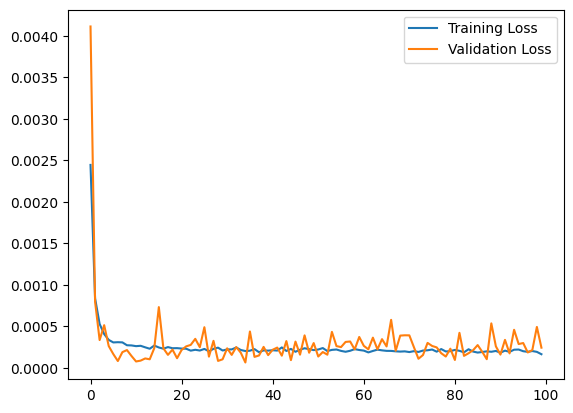

23/23 [==============================] - 0s 682us/step


In [27]:
mae_ann, mse_ann, r2_ann, pred_ann, test_ann = ann(scaled_target)

In [28]:
print(f"Mean Absolute Error: {mae_ann}\nMean Squared Error: {mse_ann}\nR2 Score: {r2_ann}")

Mean Absolute Error: 0.20458530884306997
Mean Squared Error: 0.07139827265416973
R2 Score: -1373.7713095629001


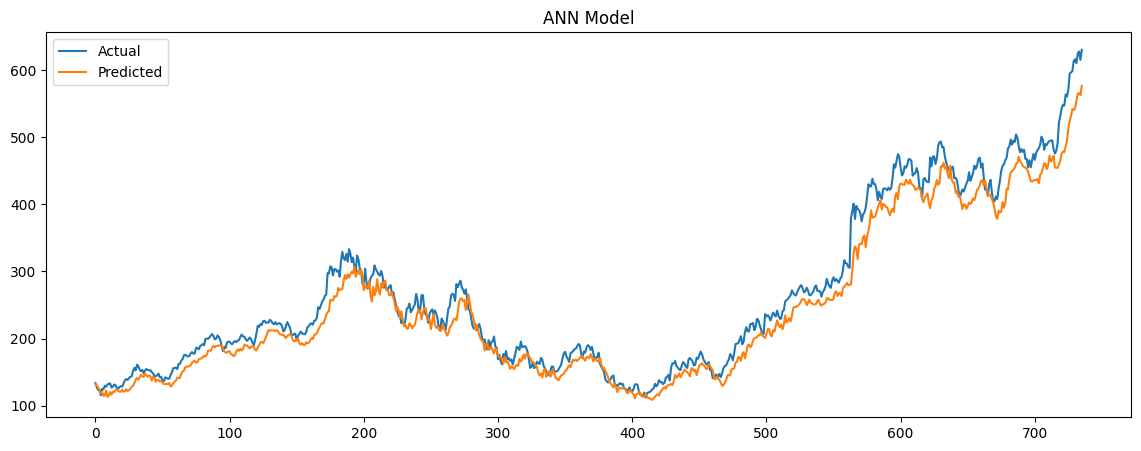

In [29]:
# Plotting the predicted and actual values
plt.figure(figsize=(14,5))
plt.plot(scaler.inverse_transform(test_ann.reshape(-1,1)), label='Actual')
plt.plot(scaler.inverse_transform(pred_ann), label='Predicted')
plt.title('ANN Model')
plt.legend()
plt.show()